# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
data[:5]

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


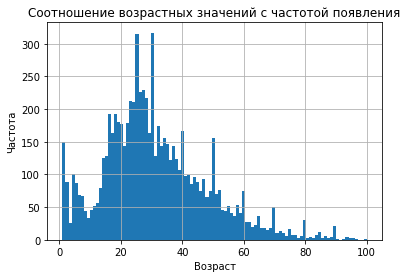

In [4]:
print(data['real_age'].describe())
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Соотношение возрастных значений с частотой появления')
data['real_age'].hist(bins=100);

**в таблице содержаться фотографии людей в возрасте от 1 года до 100 лет, 75% значений находяться в промежутке 1 - 41, в таблице содержится 7591 фотография, для того чтобы предсказания модели были более качественны в реальной задаче количество фотографий для тренировочной и тестовой выборки следовало бы увеличить**

In [5]:
%%time
images = ImageDataGenerator(rescale=1./255)
images_flow = images.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

x_train, y_train = next(images_flow)

Found 7591 validated image filenames.
CPU times: user 648 ms, sys: 391 ms, total: 1.04 s
Wall time: 1min 29s


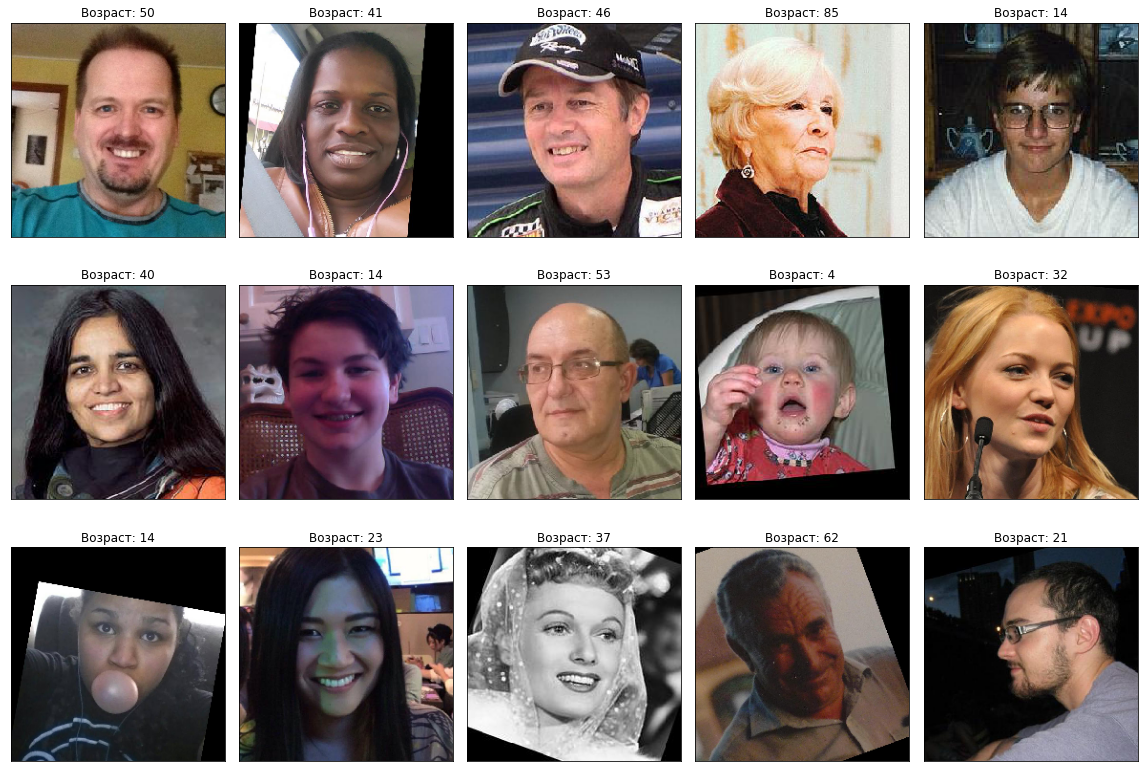

In [6]:
fig = plt.figure(figsize=(16,12))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст: ' + str(y_train[i]))

**1. Мы сможем построить модель и решить задачу, но для реальной задачи выборка мала, в тренировчных заданиях мы работали с выборками из 60000 тренировочных и 10000 тестовых картинок, такое количество более репрезентативно**

**2. Целевой признак находится в диапозоне от 1 до 100 лет, 75% значений возраста находятся до 41 года, наблюдаються резкие спады около возраста 10 лет и после 60 лет**

**3. На предоставленных фото мы видим людей, которые находяться в разных позах, при разном освещении, некоторые фотографии черно-белые, некоторые цветные**

## Обучение модели

```python
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0003)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

        model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```


Epoch 1/10
356/356 - 69s - loss: 186.9690 - mae: 10.3273 - val_loss: 442.2202 - val_mae: 15.9456
Epoch 2/10
356/356 - 61s - loss: 95.4507 - mae: 7.4665 - val_loss: 169.7255 - val_mae: 10.1027
Epoch 3/10
356/356 - 75s - loss: 60.5126 - mae: 6.0005 - val_loss: 92.2176 - val_mae: 7.4137
Epoch 4/10
356/356 - 67s - loss: 40.2434 - mae: 4.9170 - val_loss: 152.0574 - val_mae: 9.3676
Epoch 5/10
356/356 - 74s - loss: 29.6038 - mae: 4.1951 - val_loss: 102.6975 - val_mae: 7.5579
Epoch 6/10
356/356 - 71s - loss: 22.0965 - mae: 3.6445 - val_loss: 84.7509 - val_mae: 7.0877
Epoch 7/10
356/356 - 75s - loss: 17.3873 - mae: 3.1934 - val_loss: 76.7254 - val_mae: 6.6846
Epoch 8/10
356/356 - 72s - loss: 14.6387 - mae: 2.9266 - val_loss: 77.4078 - val_mae: 6.6957
Epoch 9/10
356/356 - 46s - loss: 13.9728 - mae: 2.8820 - val_loss: 90.2207 - val_mae: 7.4566
Epoch 10/10
356/356 - 57s - loss: 13.1962 - mae: 2.7893 - val_loss: 96.9586 - val_mae: 7.4748
```

## Анализ обученной модели

1. При количестве эпох 10 модель ошибается примерно на 7.5 лет
2. Описание выбранной модели: 10 эпох, ResNet50(include_top=False), веса ImageNet, в качестве loss функции взята MSE, также был использован алгоритм Adam(learning_rate=0.003)